--- [Step 0: Installing and Importing Libraries] ---
Cloning into 'Amthal'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 76 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 1.47 MiB | 2.81 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Amthal/Amthal
--- [Step 1: Loading Data] ---
Data loaded successfully. Found 4078 instances.

Calculating standardized residuals...
Generating the standardized residuals plot...


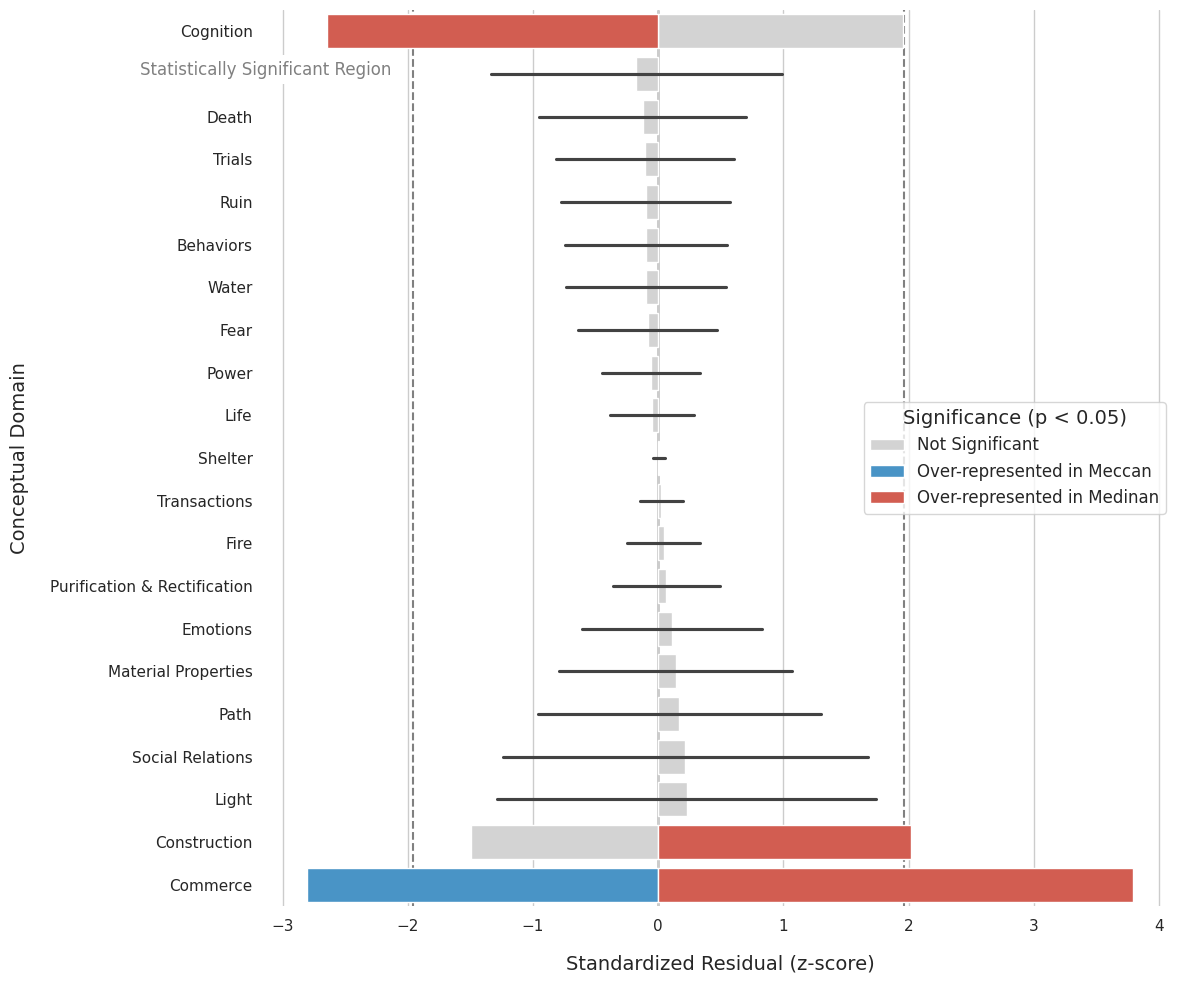

In [ ]:
#@title  **Standardized residuals of conceptual domains across revelation periods**


# --- [الخطوة 0: التثبيت والاستيراد] ---
print("--- [Step 0: Installing and Importing Libraries] ---")
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
print("--- [Step 1: Loading Data] ---")
# ⚠️⚠️⚠️  الرجاء التأكد من أن هذا المسار صحيح في بيئتك
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()


# ترجمة عمود Revelation_Phase إلى الإنجليزية
phase_map = {'مكي': 'Meccan', 'مدني': 'Medinan'}
df['Revelation_Phase_En'] = df['Revelation_Phase'].map(phase_map)


# --- 2. حساب البقايا المعيارية الصحيحة ---
print("Calculating standardized residuals...")

raw_counts = pd.crosstab(df['Dominant_Concept'], df['Revelation_Phase_En'])
chi2, p, dof, expected = chi2_contingency(raw_counts)
epsilon = 1e-9
std_residuals = (raw_counts - expected) / np.sqrt(expected + epsilon)

# فرز النتائج بناءً على قيمة البقايا المعيارية للفترة المكية لإظهار الاستقطاب
std_residuals_sorted = std_residuals.sort_values(by='Meccan', ascending=False)


# --- 3. إعداد الرسم البياني الاحترافي ---
print("Generating the standardized residuals plot...")
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 10))

# تحويل البيانات إلى "long format" للرسم
plot_data = std_residuals_sorted.reset_index().melt(
    id_vars='Dominant_Concept',
    var_name='Period',
    value_name='Standardized_Residual'
)

# إنشاء الرسم البياني بالأعمدة
# سنستخدم لونًا مختلفًا للمفاهيم المهمة إحصائيًا
def assign_color(row):
    if abs(row['Standardized_Residual']) >= 1.96:
        return row['Period'] # استخدم اللون الأساسي للفترة
    else:
        return 'Not Significant' # لون محايد لغير المهم

plot_data['Significance'] = plot_data.apply(assign_color, axis=1)

barplot = sns.barplot(
    data=plot_data,
    y='Dominant_Concept',
    x='Standardized_Residual',
    hue='Significance',
    # لوحة ألوان مخصصة
    palette={'Meccan': '#3498db', 'Medinan': '#e74c3c', 'Not Significant': 'lightgrey'},
    dodge=False, # dodge=False لرسم الأعمدة فوق بعضها البعض
    ax=ax
)


# --- 4. إضافة التحسينات البصرية ---
#ax.set_title('Figure 7. Standardized residuals of conceptual domains across revelation periods', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Standardized Residual (z-score)', fontsize=14, labelpad=15)
ax.set_ylabel('Conceptual Domain', fontsize=14, labelpad=15)

# إضافة خطوط الدلالة الإحصائية
ax.axvline(x=1.96, color='grey', linestyle='--', linewidth=1.5, zorder=0)
ax.axvline(x=-1.96, color='grey', linestyle='--', linewidth=1.5, zorder=0)
ax.text(0, 1.02, 'Statistically Significant Region', transform=ax.get_yaxis_transform(),
        color='grey', ha='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='none'))

ax.axvline(x=0, color='black', linestyle='-', linewidth=1.0, zorder=0)

# تحسين الأسطورة
handles, labels = ax.get_legend_handles_labels()
# إعادة تسمية للتوضيح
label_map = {'Meccan': 'Over-represented in Meccan', 'Medinan': 'Over-represented in Medinan', 'Not Significant': 'Not Significant'}
ax.legend(handles, [label_map[l] for l in labels], title='Significance (p < 0.05)', fontsize=12, title_fontsize=14)

sns.despine(left=True, bottom=True)

# --- 5. الحفظ والعرض ---
plt.tight_layout()
plt.savefig('Figure_6a_Standardized_Residuals_V2.png', dpi=300, bbox_inches='tight')
plt.show()